In [154]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM, SimpleRNN, GRU
from tensorflow.keras.layers import Dense

In [2]:
data = pd.read_csv(r"C:\Users\Meenatchi\Downloads\Ecommerce Data Classification\ecommerceDataset.csv", header=None)

In [3]:
data.shape

(50425, 2)

In [4]:
data.rename(columns={0: 'Category', 1: 'Description'}, inplace=True)

In [5]:
data.head()

,Category,Description
0,Household,Paper Plane Design Framed Wall Hanging Motivat...
1,Household,"SAF 'Floral' Framed Painting (Wood, 30 inch x ..."
2,Household,SAF 'UV Textured Modern Art Print Framed' Pain...
3,Household,"SAF Flower Print Framed Painting (Synthetic, 1..."
4,Household,Incredible Gifts India Wooden Happy Birthday U...


In [80]:
data['Category'].unique()

array(['Household', 'Books', 'Clothing & Accessories', 'Electronics'],
      dtype=object)

In [6]:
data.isnull().sum()

Category       0
Description    1
dtype: int64

In [7]:
data.dropna(inplace=True)

## Encoding Categorical Dependent Variable

In [10]:
data_new = pd.get_dummies(data, columns=['Category'])

In [11]:
data_new['Description'] = data_new['Description'].apply(lambda x: x.split()[:25]).apply(lambda x: ' '.join(x))

In [12]:
data_new.columns

Index(['Description', 'Category_Books', 'Category_Clothing & Accessories',
       'Category_Electronics', 'Category_Household'],
      dtype='object')

## Independent and Dependent Variables

In [13]:
X = data_new['Description']
y = data_new.drop(['Description'], axis=1)

In [14]:
X.shape

(50424,)

In [15]:
y.shape

(50424, 4)

## One Hot Representation

In [17]:
description = pd.DataFrame(X.copy())

In [18]:
description.reset_index(inplace=True)

In [19]:
import nltk
import re
from nltk.corpus import stopwords

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Meenatchi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Data Preprocessing

In [20]:
from nltk.stem.porter import PorterStemmer ##stemming purpose
ps = PorterStemmer()
corpus = []
for i in range(0, len(description)):
    review = re.sub('[^a-zA-Z]', ' ', description['Description'][i])
    review = review.lower()
    review = review.split()

    review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    corpus.append(review)

In [21]:
voc_size = 10000

onehot_repr=[one_hot(words,voc_size)for words in corpus]

## Embedding Representation

In [23]:
sent_length=25
embedded_docs=pad_sequences(onehot_repr,padding='pre',maxlen=sent_length)
print(embedded_docs)

[[   0    0    0 ... 2410 8099 5223]
 [   0    0    0 ... 5223 3606 8653]
 [   0    0    0 ...  538 2916 3958]
 ...
 [   0    0    0 ... 9927 7887 7303]
 [   0    0    0 ... 7660 8059 1288]
 [   0    0    0 ... 8131 4345 3718]]


## Creating Models - RNN, LSTM, GRU

#### RNN

In [127]:
## Creating model
embedding_vector_features=30 ##features representation

model1=Sequential()
model1.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
model1.add(SimpleRNN(100))
model1.add(Dense(4,activation='softmax'))
model1.build(input_shape=(None, sent_length))
model1.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model1.summary())

C:\Users\Meenatchi\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 25, 30)         │       300,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 100)            │        13,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           404 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 313,504 (1.20 MB)

 Trainable params: 313,504 (1.20 MB)

 Non-trainable params: 0 (0.00 B)

None


In [129]:
len(embedded_docs),y.shape

(50424, (50424, 4))

In [130]:
import numpy as np
X_final=np.array(embedded_docs)
y_final=np.array(y)

In [131]:
X_final.shape,y_final.shape

((50424, 25), (50424, 4))

In [132]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.33, random_state=42)

### Model Training - RNN

In [134]:
### Finally Training
model1.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=10,batch_size=64)

Epoch 1/10
528/528 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - accuracy: 0.7168 - loss: 0.7023 - val_accuracy: 0.9572 - val_loss: 0.1635
Epoch 2/10
528/528 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - accuracy: 0.9726 - loss: 0.1069 - val_accuracy: 0.9581 - val_loss: 0.1533
Epoch 3/10
528/528 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.9869 - loss: 0.0508 - val_accuracy: 0.9639 - val_loss: 0.1304
Epoch 4/10
528/528 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.9919 - loss: 0.0310 - val_accuracy: 0.9657 - val_loss: 0.1333
Epoch 5/10
528/528 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.9958 - loss: 0.0168 - val_accuracy: 0.9661 - val_loss: 0.1488
Epoch 6/10
528/528 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.9980 - loss: 0.0105 - val_accuracy: 0.9650 - val_loss: 0.1620
Epoch 7/10
528/528 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.9983 - loss: 0.0067 - val_accuracy: 0.9644 - val_loss: 0.1639
Epoch 8/10
528/528 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.9948 - loss: 0.0173 - val_acc

### Model Prediction - RNN

In [136]:
y_pred=model1.predict(X_test)

520/520 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step


In [137]:
y_pred=np.where(y_pred > 0.5, 1,0) ##AUC ROC Curve

In [138]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test,y_pred)

0.9678485576923077

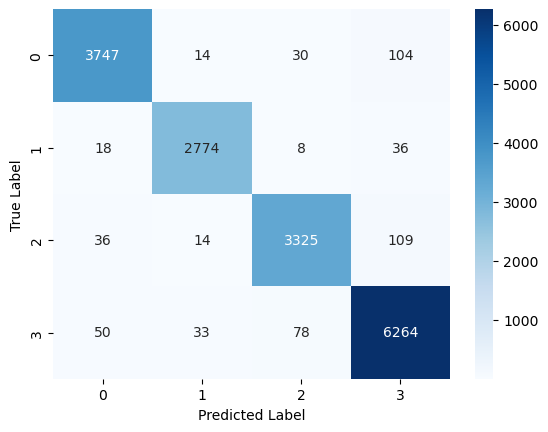

In [139]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Converting y_test and y_pred to same format
y_test = np.argmax(y_test, axis=1)
y_pred_classes = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_test, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

#### LSTM

In [141]:
## Creating model
embedding_vector_features=30 ##features representation

model2=Sequential()
model2.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
model2.add(LSTM(100))
model2.add(Dense(4,activation='softmax'))
model2.build(input_shape=(None, sent_length))
model2.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model2.summary())

C:\Users\Meenatchi\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, 25, 30)         │       300,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 100)            │        52,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           404 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 352,804 (1.35 MB)

 Trainable params: 352,804 (1.35 MB)

 Non-trainable params: 0 (0.00 B)

None


In [142]:
X_final=np.array(embedded_docs)
y_final=np.array(y)

In [143]:
X_final.shape,y_final.shape

((50424, 25), (50424, 4))

In [144]:
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.33, random_state=42)

#### Model Training - LSTM

In [146]:
### Model Training
model2.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=10,batch_size=64)

Epoch 1/10
528/528 ━━━━━━━━━━━━━━━━━━━━ 22s 31ms/step - accuracy: 0.7517 - loss: 0.6267 - val_accuracy: 0.9554 - val_loss: 0.1683
Epoch 2/10
528/528 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - accuracy: 0.9733 - loss: 0.1020 - val_accuracy: 0.9566 - val_loss: 0.1533
Epoch 3/10
528/528 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - accuracy: 0.9856 - loss: 0.0583 - val_accuracy: 0.9660 - val_loss: 0.1295
Epoch 4/10
528/528 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - accuracy: 0.9896 - loss: 0.0397 - val_accuracy: 0.9660 - val_loss: 0.1423
Epoch 5/10
528/528 ━━━━━━━━━━━━━━━━━━━━ 20s 29ms/step - accuracy: 0.9929 - loss: 0.0280 - val_accuracy: 0.9677 - val_loss: 0.1370
Epoch 6/10
528/528 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - accuracy: 0.9938 - loss: 0.0258 - val_accuracy: 0.9675 - val_loss: 0.1553
Epoch 7/10
528/528 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - accuracy: 0.9962 - loss: 0.0155 - val_accuracy: 0.9686 - val_loss: 0.1584
Epoch 8/10
528/528 ━━━━━━━━━━━━━━━━━━━━ 16s 31ms/step - accuracy: 0.9954 - loss: 0.0169 - 

#### Model Prediction - LSTM

In [148]:
y_pred=model2.predict(X_test)

520/520 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step


In [149]:
y_pred=np.where(y_pred > 0.5, 1,0) ##AUC ROC Curve

In [150]:
accuracy_score(y_test,y_pred)

0.9658653846153846

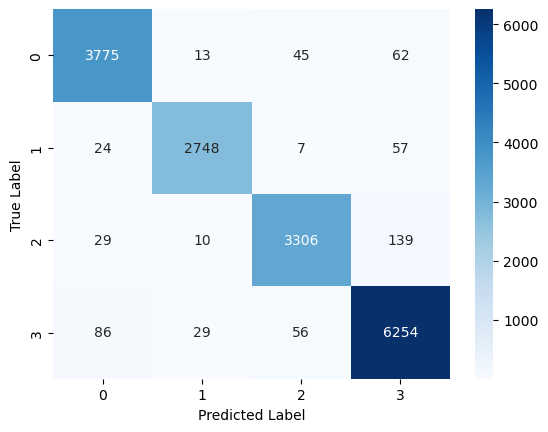

In [151]:
# Converting y_test and y_pred to same format
y_test = np.argmax(y_test, axis=1)
y_pred_classes = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_test, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### GRU 

In [191]:
## Creating model
embedding_vector_features=30 ##features representation

model3=Sequential()
model3.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
model3.add(GRU(100))
model3.add(Dense(4,activation='softmax'))
model3.build(input_shape=(None, sent_length))
model3.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model3.summary())

C:\Users\Meenatchi\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_9 (Embedding)         │ (None, 25, 30)         │       300,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_4 (GRU)                     │ (None, 100)            │        39,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 4)              │           404 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 340,004 (1.30 MB)

 Trainable params: 340,004 (1.30 MB)

 Non-trainable params: 0 (0.00 B)

None


In [192]:
X_final=np.array(embedded_docs)
y_final=np.array(y)

In [193]:
X_final.shape,y_final.shape

((50424, 25), (50424, 4))

In [194]:
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.33, random_state=42)

### Model Training - GRU

In [196]:
### Model Training
model3.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=10,batch_size=64)

Epoch 1/10
528/528 ━━━━━━━━━━━━━━━━━━━━ 24s 34ms/step - accuracy: 0.7192 - loss: 0.6721 - val_accuracy: 0.9594 - val_loss: 0.1514
Epoch 2/10
528/528 ━━━━━━━━━━━━━━━━━━━━ 17s 32ms/step - accuracy: 0.9745 - loss: 0.0982 - val_accuracy: 0.9618 - val_loss: 0.1339
Epoch 3/10
528/528 ━━━━━━━━━━━━━━━━━━━━ 17s 31ms/step - accuracy: 0.9869 - loss: 0.0504 - val_accuracy: 0.9641 - val_loss: 0.1297
Epoch 4/10
528/528 ━━━━━━━━━━━━━━━━━━━━ 17s 32ms/step - accuracy: 0.9920 - loss: 0.0309 - val_accuracy: 0.9673 - val_loss: 0.1267
Epoch 5/10
528/528 ━━━━━━━━━━━━━━━━━━━━ 17s 32ms/step - accuracy: 0.9942 - loss: 0.0230 - val_accuracy: 0.9660 - val_loss: 0.1423
Epoch 6/10
528/528 ━━━━━━━━━━━━━━━━━━━━ 16s 31ms/step - accuracy: 0.9958 - loss: 0.0148 - val_accuracy: 0.9686 - val_loss: 0.1433
Epoch 7/10
528/528 ━━━━━━━━━━━━━━━━━━━━ 21s 32ms/step - accuracy: 0.9965 - loss: 0.0114 - val_accuracy: 0.9693 - val_loss: 0.1522
Epoch 8/10
528/528 ━━━━━━━━━━━━━━━━━━━━ 18s 33ms/step - accuracy: 0.9972 - loss: 0.0106 - 

### Model Prediction - GRU

In [198]:
y_pred=model3.predict(X_test)

520/520 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step


In [199]:
y_pred=np.where(y_pred > 0.5, 1,0) ##AUC ROC Curve

In [200]:
accuracy_score(y_test,y_pred)

0.9670673076923076

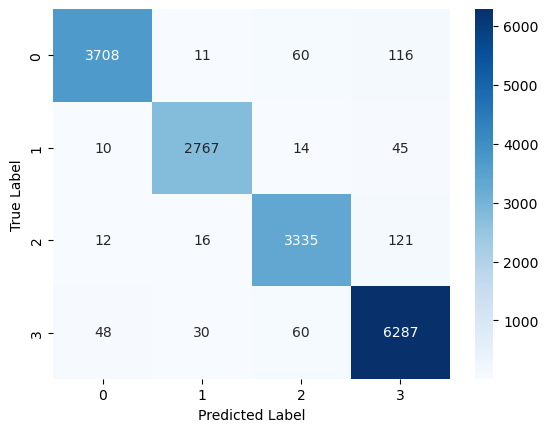

In [201]:
# Converting y_test and y_pred to same format
y_test = np.argmax(y_test, axis=1)
y_pred_classes = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_test, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Comparison of Results

#### 1. Accuracy of RNN : 96.78%
#### 2. Accuracy of LSTM : 96.58%
#### 3. Accuracy of GRU : 96.70%